# Load data and simple visualizing

In [539]:
import pandas as pd

In [540]:
col = ['Date', 'Open', 'High', 'Low', 'Close', 'Change(Pips)', 'Change(%)']

In [541]:
df = pd.read_csv('XAUUSD.csv')

In [542]:
df = df.set_axis(col, axis=1)[1:]

In [543]:
df.describe()

,Date,Open,High,Low,Close,Change(Pips),Change(%)
count,622,622,622,622,622,622,622
unique,622,613,616,610,617,577,264
top,7/4/2023 0:00,1825.69,1812.03,1699.2,1746.74,123,-0.1
freq,1,2,2,2,2,3,9


In [544]:
df.head()

,Date,Open,High,Low,Close,Change(Pips),Change(%)
1,7/4/2023 0:00,1921.07,1930.22,1920.34,1929.65,858,0.44
2,7/3/2023 0:00,1917.7,1930.5,1910.11,1921.17,347,0.18
3,7/2/2023 0:00,1920.3,1920.3,1917.5,1917.7,-260,-0.14
4,6/30/2023 0:00,1908.71,1922.61,1900.57,1919.2,1049,0.55
5,6/29/2023 0:00,1909.47,1913,1893.16,1908.76,-71,-0.04


## Check Nan values

In [545]:
def check_nan(data):
    
    nan_counts = data.isnull().sum().to_dict()
    return nan_counts

nan_counts = check_nan(df)

for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

Column 'Date': 0 NaN values
Column 'Open': 0 NaN values
Column 'High': 0 NaN values
Column 'Low': 0 NaN values
Column 'Close': 0 NaN values
Column 'Change(Pips)': 0 NaN values
Column 'Change(%)': 0 NaN values


# Find best paramerters

In [546]:
data = df[['Close']].copy()
data = data.astype(float)

In [547]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data)
print(f"p-value: {result[1]}")

p-value: 0.2635240067860788


## Finding d

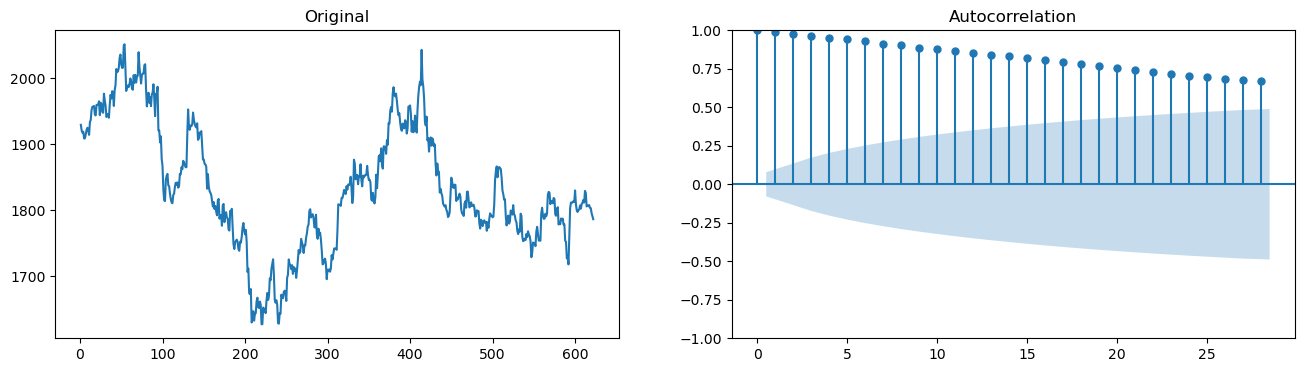

In [548]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(data)
ax1.set_title("Original")
plot_acf(data, ax = ax2);

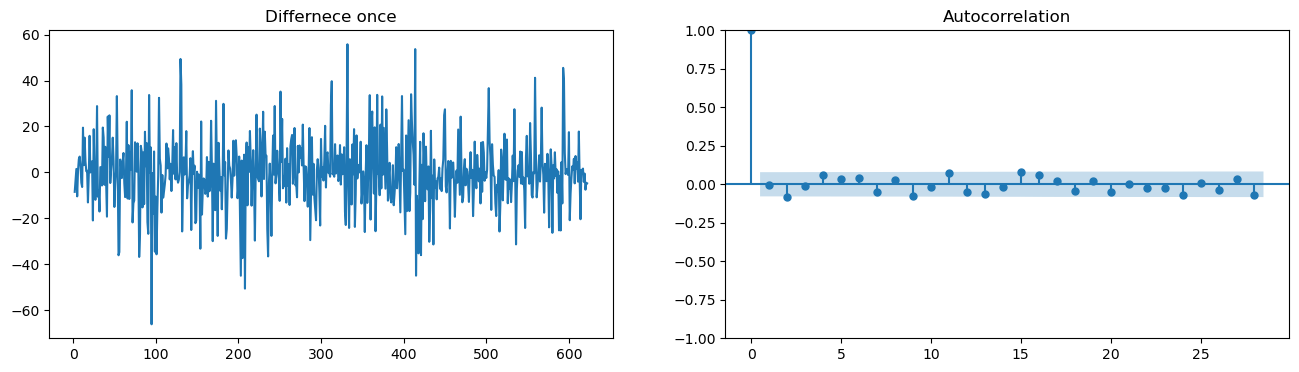

In [549]:
diff = data.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differnece once")
plot_acf(diff, ax = ax2);

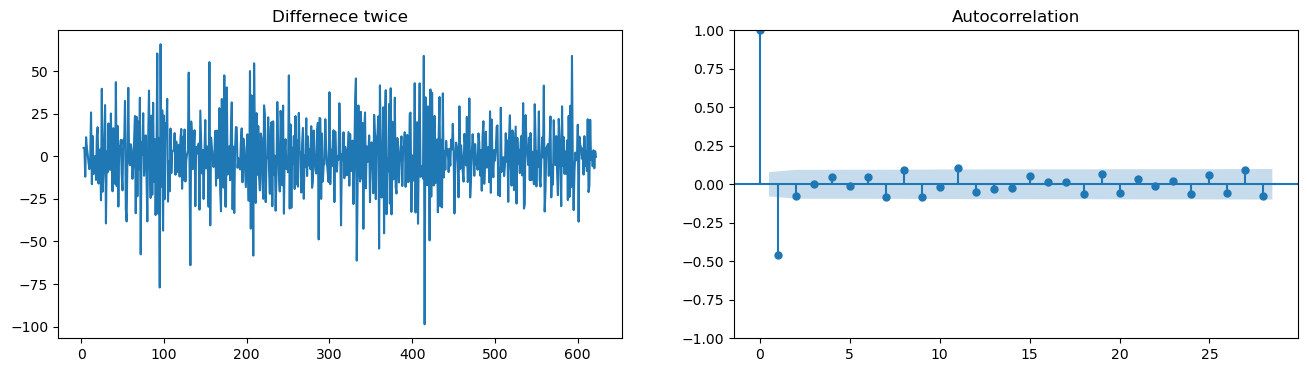

In [550]:
diff = data.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differnece twice")
plot_acf(diff, ax = ax2);

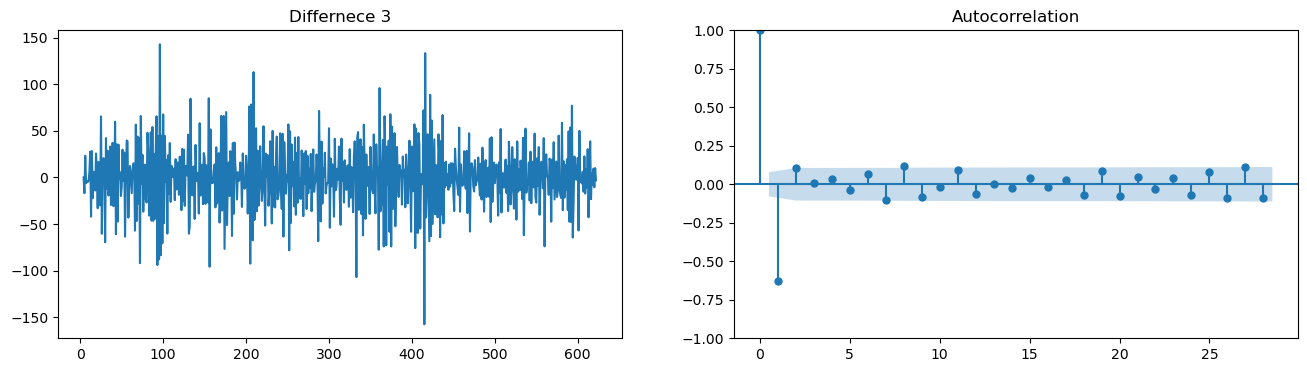

In [551]:
diff = data.diff().diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differnece 3")
plot_acf(diff, ax = ax2);

**The value of d, therefore, is the minimum number of differencing needed to make the series stationary.
That is, subtract the previous value from the current value. Sometimes, depending on the complexity of the series, more than one differencing may be needed.After the first/second change (d = 2 or d = 1), according to the plots of differences, the model became stable and hasn't change anymore.**

**d = 1/2 ?**

## Finding p and q

C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


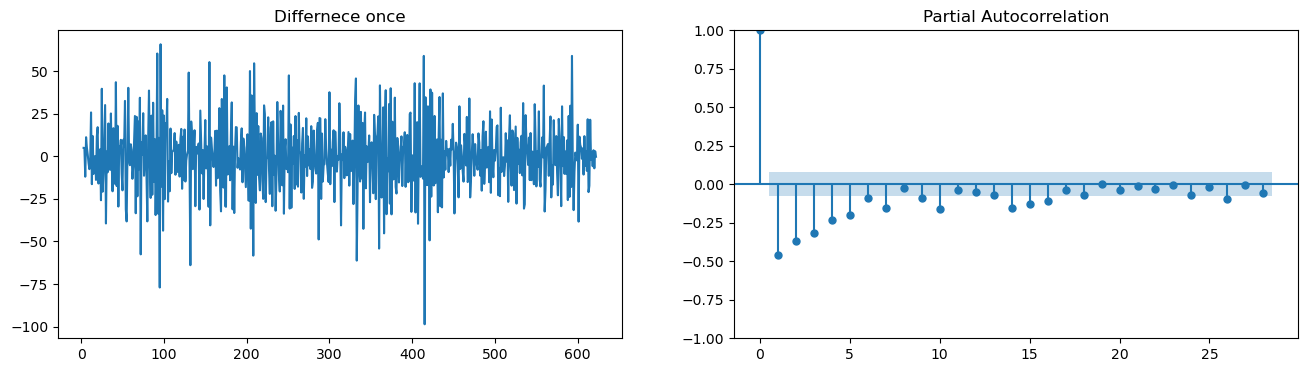

In [553]:
from statsmodels.graphics.tsaplots import plot_pacf

diff = data.diff().diff().dropna()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(diff)
ax1.set_title("Differnece once")
plot_pacf(diff, ax = ax2);

**To find out the value of q we can use the ACF plot. Which will tell us how much moving average is required to remove the autocorrelation from the stationary time series. Here we can see that 5 of the lags are out of the significance limit which will use grid search to find best paramater.

** 

**p = 1/2/3/4/5 ?
q = 3/4/5...8 ?**

# Grid Search

In [606]:
def mean_absolute_percentage_error(actual_values, predicted_values):
    
    import numpy as np
    actual_values = np.array(actual_values)
    predicted_values = np.array(predicted_values)

    epsilon = 1e-10
    percentage_errors = np.abs((actual_values - predicted_values) / np.maximum(actual_values, epsilon))
    mape = np.mean(percentage_errors) * 100

    return mape

In [607]:
iters = []
for q in range(2,8):
    for d in range(1,3):
        for p in range(0,5):
            iters.append([q, d, p])

In [623]:
from statsmodels.tsa.arima.model import ARIMA
results = {}
for iter in iters:
    model = ARIMA(data, order = (iter[0],iter[1],iter[2]))
    result = model.fit()
    pred = result.predict(start = data.index[0] , end = data.index[-1])
    results[str(iter)] = f'mape = {mean_absolute_percentage_error(data, pred)}, AIC = {result.aic}'

C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\11\anaconda3\env

C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\11\anaconda3\envs\Pytorch\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\11\anaconda3\env

In [624]:
list(sorted(results.items(), key=lambda item: item[1]))

[('[5, 1, 2]', 'mape = 5.805694409774624, AIC = 5114.879910673248'),
 ('[7, 1, 2]', 'mape = 5.820497268066836, AIC = 5113.895508201869'),
 ('[7, 1, 3]', 'mape = 5.820602713367587, AIC = 5113.492908082149'),
 ('[3, 1, 1]', 'mape = 5.822653611455993, AIC = 5109.574671612158'),
 ('[3, 1, 0]', 'mape = 5.822726919809846, AIC = 5108.946984708166'),
 ('[2, 1, 1]', 'mape = 5.82289355327603, AIC = 5108.9972889701685'),
 ('[2, 1, 0]', 'mape = 5.823051434350908, AIC = 5107.036556310404'),
 ('[6, 1, 3]', 'mape = 5.823602832169972, AIC = 5112.310076615884'),
 ('[2, 1, 2]', 'mape = 5.8238095316256535, AIC = 5106.550794258507'),
 ('[4, 1, 0]', 'mape = 5.824292111770141, AIC = 5109.325099341164'),
 ('[3, 1, 3]', 'mape = 5.82434510511922, AIC = 5110.1174696964445'),
 ('[7, 1, 4]', 'mape = 5.824349786213994, AIC = 5112.13926106278'),
 ('[3, 1, 2]', 'mape = 5.824438494707094, AIC = 5108.283705044309'),
 ('[2, 1, 3]', 'mape = 5.824456988787538, AIC = 5108.266332126306'),
 ('[6, 1, 4]', 'mape = 5.824585561

**[2,1,0] has lowest AIC, and it's on 10 top lowest loss**

# Arima

In [647]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data, order = (2,1,0))
result = model.fit()

In [648]:
result.aic

5107.036556310404

In [649]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  622
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2550.518
Date:                Fri, 21 Jul 2023   AIC                           5107.037
Time:                        17:33:02   BIC                           5120.331
Sample:                             0   HQIC                          5112.204
                                - 622                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0029      0.036     -0.079      0.937      -0.074       0.068
ar.L2         -0.0835      0.037     -2.236      0.025      -0.157      -0.010
sigma2       216.2270      8.927     24.221      0.000     198.730     233.724
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                82.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.64   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**coef ~= 0**

In [660]:
pred = result.predict(start = data.index[0] , end = data.index[-1])

In [663]:
forecast = result.forecast(30)

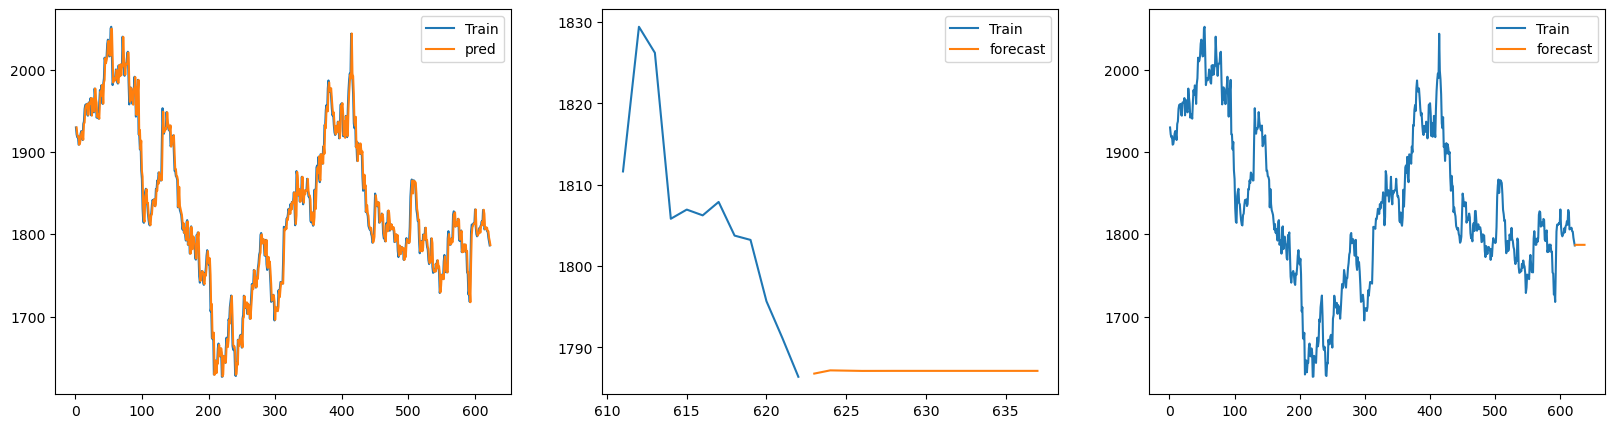

In [673]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.plot(data, label='Train')
# Plot the predicted values
ax1.plot(pred, label='pred')
ax1.legend()


ax2.plot(data[610:], label='Train')
ax2.plot(forecast, label='forecast')
ax2.legend()

ax3.plot(data, label='Train')
ax3.plot(forecast, label='forecast')
ax3.legend()

# Show the plot
plt.show()

In [674]:
mean_absolute_percentage_error(data, pred)

5.823051434350908